In [1]:
from unityagents import UnityEnvironment
from collections import OrderedDict, deque

import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import copy

import matplotlib.pyplot as plt

In [2]:
env = UnityEnvironment(file_name='Reacher.app')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [3]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):

    def __init__(self, state_size, action_size, fc1_units, fc2_units):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):

    def __init__(self, state_size, action_size, fc1_units, fc2_units):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.relu(self.fc1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
hidden_layers = [128, 64]
max_memory = 100000
batch_size = 128
learning_rate = 0.0001
tau = 0.001
gamma = 0.99
update_every = 4

class Agent():
    
    def __init__(self, state_size, action_size, checkpoint = None):
        self.state_size = state_size
        self.action_size = action_size
        
        self.actor_local = Actor(state_size, action_size, hidden_layers[0], hidden_layers[1])
        self.actor_target = Actor(state_size, action_size, hidden_layers[0], hidden_layers[1])
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=learning_rate)

        self.critic_local = Critic(state_size, action_size, hidden_layers[0], hidden_layers[1])
        self.critic_target = Critic(state_size, action_size, hidden_layers[0], hidden_layers[1])
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=learning_rate)

        if checkpoint is not None:
            self.actor_local.load_state_dict(checkpoint['actor_local'])
            self.actor_target.load_state_dict(checkpoint['actor_target'])
            self.critic_local.load_state_dict(checkpoint['critic_local'])
            self.critic_target.load_state_dict(checkpoint['critic_target'])

        self.memory = deque(maxlen=max_memory)
        self.t_step = 0
        
    def get_action(self, state):
        
        state = torch.from_numpy(state).float().unsqueeze(0)
        
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(state)
        self.actor_local.train()
        
        return actions.detach().numpy()

    def train(self, state, action, reward, next_state, done):
        self.memory.append({
            "state": state,
            "action": action,
            "reward": reward,
            "next_state": next_state,
            "done": done
        })
        
        self.t_step = (self.t_step + 1) % update_every
        if self.t_step == 0:
            if len(self.memory) > batch_size:
                experiences = random.sample(self.memory, k = batch_size)
                
                states = torch.from_numpy(np.vstack([e['state'] for e in experiences if e is not None])).float()
                actions = torch.from_numpy(np.vstack([e['action'] for e in experiences if e is not None])).float()
                rewards = torch.from_numpy(np.vstack([e['reward'] for e in experiences if e is not None])).float()
                next_states = torch.from_numpy(np.vstack([e['next_state'] for e in experiences if e is not None])).float()
                dones = torch.from_numpy(np.vstack([e['done'] for e in experiences if e is not None]).astype(np.uint8)).float()
                
                actions_next = self.actor_target(next_states)
                Q_targets_next = self.critic_target(next_states, actions_next)
                Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
                Q_expected = self.critic_local(states, actions)
                critic_loss = F.mse_loss(Q_expected, Q_targets)

                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

                actions_pred = self.actor_local(states)
                actor_loss = -self.critic_local(states, actions_pred).mean()
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                self.soft_update(self.critic_local, self.critic_target, tau)
                self.soft_update(self.actor_local, self.actor_target, tau)                     

                
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



# Training

Episode 100, Average 1.0301999769732355
Episode 200, Average 2.3359999477863314
Episode 300, Average 7.0397998426482085
Episode 400, Average 14.962999665550887
Episode 500, Average 20.21069954825565
Episode 600, Average 27.39739938762039
Solved in 657 episodes with a score of 30.039599328562616


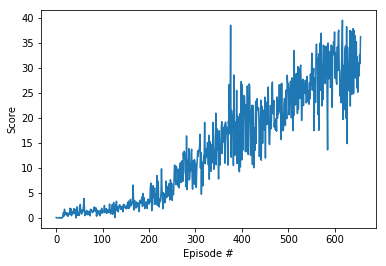

In [5]:
checkpoint_filename = 'checkpoint.pth'
number_of_episodes = 2000

env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]
state_size = len(state)
action_size = brain.vector_action_space_size

agent = Agent(state_size, action_size)

all_scores = []
scores = deque(maxlen=100)

state_dict_score = 0

if os.path.exists(checkpoint_filename):
    checkpoint = torch.load(checkpoint_filename)
    if checkpoint:
        state_dict_score = checkpoint['score']

for episode in range(1, number_of_episodes + 1):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    episode_score = 0

    done = False
    while not done:
        action = agent.get_action(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]

        agent.train(state, action, reward, next_state, done)
        state = next_state
        
        # Save scores
        episode_score += reward

    scores.append(episode_score)
    all_scores.append(episode_score)
    average_score = np.mean(scores)
    
    if episode % 100 == 0:
        print('Episode {}, Average {}'.format(episode, average_score))
    
    if average_score > state_dict_score:
        state_dict_score = average_score
        torch.save({
            "score": average_score,
            "actor_local": agent.actor_local.state_dict(),
            "actor_target": agent.actor_target.state_dict(),
            "critic_local": agent.critic_local.state_dict(),
            "critic_target": agent.critic_target.state_dict()
        }, checkpoint_filename)
        
    if average_score > 30:
        print('Solved in {} episodes with a score of {}'.format(episode, average_score))
        break

# plot the scores
fig = plt.figure()
plt.plot(np.arange(len(all_scores)), all_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Playback

In [6]:
checkpoint_filename = 'checkpoint.pth'
checkpoint = torch.load(checkpoint_filename)

print('Loading checkpoint with score of ', checkpoint['score'])

env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
state_size = len(state)
action_size = brain.vector_action_space_size

agent = Agent(state_size, action_size, checkpoint)

done = False
while not done:
    action = agent.get_action(state)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    state = next_state


Loading checkpoint with score of  30.039599328562616


In [7]:
## To close the unity environment
env.close()